In [1]:
import os
import torchvision
import torch
from torchvision import datasets, transforms
from PIL import Image, UnidentifiedImageError
from torch.utils.data import DataLoader, random_split, Dataset
import warnings
from tqdm.auto import tqdm
from PIL import Image

# Suppress all warnings
warnings.filterwarnings("ignore")

DATA_PATH = "/kaggle/input/microsoft-catsvsdogs-dataset/PetImages"
IGNORE_PATHS = [
    '/kaggle/input/microsoft-catsvsdogs-dataset/PetImages/Dog/11702.jpg',
    '/kaggle/input/microsoft-catsvsdogs-dataset/PetImages/Cat/666.jpg'
]

In [2]:
data_paths = []
classes = ['Dog', 'Cat']
for i in classes:
    for j in os.listdir(os.path.join(DATA_PATH, i)):
        path = os.path.join(DATA_PATH, i,j)
        if path.endswith(".jpg") and path not in IGNORE_PATHS:
            data_paths.append(path)
len(set(data_paths))

24998

In [3]:
# Define your transformation
transformation_steps = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to a fixed size (adjust as needed)
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),           # Convert images to PyTorch tensors
])

class CustomDataset(Dataset):
    def __init__(self, data_path, transform=None):
        self.data_path = data_path  # Corrected from 'data' to 'data_path'
        self.transform = transform
#         self.class_counts = Counter()

    def __len__(self):
        return len(self.data_path)

    def __getitem__(self, idx):
        try:
            img_path = self.data_path[idx]
            img = Image.open(img_path)
            img = self.transform(img)
            label = 0 if "Dog" in img_path else 1
            return img, label
        except UnidentifiedImageError as e:
                print(f"Error processing image: {e}")
                # Replace the image with a placeholder or handle as needed
                img = Image.new('RGB', (64, 64), color='black')  # Replace with appropriate placeholder
                label = -1  # Assign a special label or handle differently
                img = self.transform(img)
                return img, label

dataset = CustomDataset(data_path=data_paths, transform=transformation_steps)

In [4]:
import torchvision
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split

# Define the split ratios
train_ratio = 0.8
test_ratio = 1 - train_ratio

# Calculate the number of samples for each split
num_train = int(train_ratio * len(dataset))
num_test = len(dataset) - num_train

# Split the dataset
train_set, test_set = random_split(dataset, [num_train, num_test])

# Create data loaders
BATCH_SIZE = 32
train_dataloader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=False)

In [5]:
len(train_dataloader), len(test_dataloader)

(625, 157)

In [6]:
625*32, 157*32

(20000, 5024)

In [7]:
from torch import nn

class DogCatClassifier(nn.Module):
    def __init__(self):
        super(DogCatClassifier, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(1, 8, kernel_size=3, stride=2),
            nn.MaxPool2d(2, 2),
            nn.ReLU(),

            nn.Conv2d(8, 16, kernel_size=3, stride=2),
            nn.MaxPool2d(2, 2),
            nn.ReLU(),

            nn.Conv2d(16, 32, kernel_size=3, stride=2),
            nn.MaxPool2d(2, 2),
            nn.ReLU(),
        )

        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(288, 128),
            nn.ReLU(),
            nn.Linear(128, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.conv(x)
        x = self.fc(x)

        return x

In [8]:
device = "cuda" if torch.cuda.is_available() else "cpu"

model = DogCatClassifier().to(device)
loss_fn = nn.BCELoss() # nn.CrossEntropyLoss() 
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [9]:
# Set number of epochs
EPOCHS = 5
total_dataset_size = len(train_dataloader)

for epoch in tqdm(range(EPOCHS)):
    model.train()
    # Training
    train_loss, train_acc = 0, 0
    for batch, (X, y) in enumerate(train_dataloader):
        X, y = X.to(device), y.to(device).to(torch.float32)
        y_pred = model(X).reshape(-1)
        y_pred_class = torch.round(y_pred)
        break
    break

  0%|          | 0/5 [00:00<?, ?it/s]

In [10]:
# Set number of epochs
EPOCHS = 20
total_dataset_size = len(train_dataloader)

for epoch in tqdm(range(EPOCHS)):
    model.train()
    # Training
    train_loss, train_acc = 0, 0
    for batch, (X, y) in enumerate(train_dataloader):
        if (batch // BATCH_SIZE) % 100 == 0:
            print(f"\rEpoch: {epoch}/{EPOCHS} | Batch: {batch}/{total_dataset_size}", end="", flush=True)
#         X, y = X.to(device), y.to(device)#.to(torch.float32)
#         y_pred_logit = model(X)
#         y_pred = torch.sigmoid(y_pred_logit).argmax(dim=1)
        X, y = X.to(device), y.to(device).to(torch.float32)
        y_pred = model(X).reshape(-1)
        loss = loss_fn(y_pred, y)
        train_loss += loss.item()
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
#         y_pred_class = torch.argmax(torch.softmax(y_pred_logit, dim=1), dim=1)
        y_pred_class = torch.round(y_pred)
        train_acc += (y_pred_class == y).sum().item() / len(y)

    # Adjust metrics to get average loss and accuracy per batch
    train_loss /= (batch + 1)  # Divide by the number of batches in the epoch
    train_acc /= (batch + 1)
    
    # Testing
    test_loss, test_acc = 0, 0
    model.eval()
    with torch.no_grad():  # Corrected from torch.inference_mode()
        for test_batch, (X, y) in enumerate(test_dataloader):
            X, y = X.to(device), y.to(device).to(torch.float32)
            test_pred_logits = model(X).reshape(-1)
            loss = loss_fn(test_pred_logits, y)
            test_loss += loss.item()
#             test_pred_labels = torch.argmax(torch.softmax(test_pred_logits, dim=1), dim=1)
            test_pred_labels = torch.round(test_pred_logits)
            test_acc += (test_pred_labels == y).sum().item() / len(y)
        test_loss /= (test_batch + 1)  # Divide by the number of batches in the testing set
        test_acc /= (test_batch + 1)
    print(f" | Train loss: {train_loss:.4f} | Train acc: {train_acc:.4f} | Test loss: {test_loss:.4f} | Test acc: {test_acc:.4f}")

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 0/20 | Batch: 31/625 | Train loss: 0.6775 | Train acc: 0.5697 | Test loss: 0.6546 | Test acc: 0.6143
Epoch: 1/20 | Batch: 31/625 | Train loss: 0.6460 | Train acc: 0.6280 | Test loss: 0.6172 | Test acc: 0.6592
Epoch: 2/20 | Batch: 31/625 | Train loss: 0.6081 | Train acc: 0.6666 | Test loss: 0.5828 | Test acc: 0.6927
Epoch: 3/20 | Batch: 31/625 | Train loss: 0.5760 | Train acc: 0.6979 | Test loss: 0.5674 | Test acc: 0.6975
Epoch: 4/20 | Batch: 31/625 | Train loss: 0.5511 | Train acc: 0.7165 | Test loss: 0.5640 | Test acc: 0.7128
Epoch: 5/20 | Batch: 31/625 | Train loss: 0.5319 | Train acc: 0.7313 | Test loss: 0.5281 | Test acc: 0.7339
Epoch: 6/20 | Batch: 31/625 | Train loss: 0.5171 | Train acc: 0.7442 | Test loss: 0.5282 | Test acc: 0.7398
Epoch: 7/20 | Batch: 31/625 | Train loss: 0.5036 | Train acc: 0.7519 | Test loss: 0.5316 | Test acc: 0.7347
Epoch: 8/20 | Batch: 31/625 | Train loss: 0.4892 | Train acc: 0.7604 | Test loss: 0.5023 | Test acc: 0.7605
Epoch: 9/20 | Batch: 31/625 

In [11]:
model.eval()  # Set the model to evaluation mode
correct = 0
total = 0

with torch.no_grad():  # Corrected from torch.inference_mode()
    for idx, (inputs, labels) in tqdm(enumerate(test_dataloader), total=len(test_dataloader)):
        inputs = inputs.to(device)
        labels = labels.to(device).to(torch.float32)

        outputs = model(inputs)
        predicted = torch.round(outputs)

        correct += (predicted.squeeze() == labels).sum().item()
        total += labels.size(0)

accuracy = correct / total if total > 0 else 0.0
print(f'Test Accuracy: {accuracy:.2%}')

  0%|          | 0/157 [00:00<?, ?it/s]

Test Accuracy: 77.88%


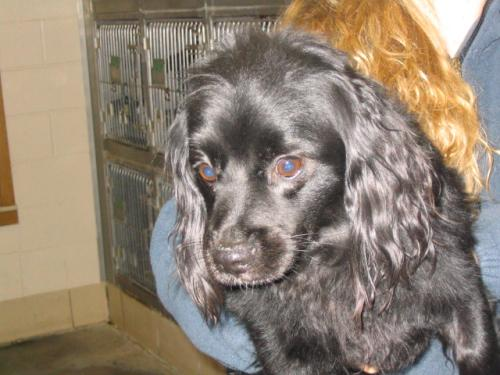

In [12]:
import random

classes = ['Dog','Cat']
random_path = random.choice(data_paths)
random_raw_img, label = Image.open(random_path), 0 if "Dog" in random_path else 1
random_img = transformation_steps(random_raw_img)

Image.open(random_path)

In [13]:
classes = ['Dog','Cat']
outputs = model(random_img.to(device).unsqueeze(0))
predicted = torch.round(outputs.squeeze())
classes[int(predicted.item())]

'Dog'

In [14]:
import numpy as np
from sklearn.metrics import confusion_matrix
# Initialize lists to store true labels and predicted labels
all_true_labels = []
all_predicted_labels = []

# Iterate through the test dataset to get predictions
with torch.no_grad():
    for inputs, labels in test_dataloader:
        inputs = inputs.to(device)
        labels = labels.to(device).to(torch.float32)
        outputs = model(inputs)
        predicted = torch.round(outputs).squeeze()

        all_true_labels.extend(labels.tolist())
        all_predicted_labels.extend(predicted.tolist())
# Convert lists to numpy arrays
true_labels_np = np.array(all_true_labels)
predicted_labels_np = np.array(all_predicted_labels)

# Create a confusion matrix
conf_matrix = confusion_matrix(true_labels_np, predicted_labels_np)

# Display the confusion matrix
print("Confusion Matrix:")
print(conf_matrix)

Confusion Matrix:
[[1930  577]
 [ 529 1964]]


In [15]:
# from collections import Counter
# class_counts = Counter()
# for batch in test_dataloader:
#     labels = batch[1]
#     class_counts.update(labels.numpy())  # Assuming labels are stored as a tensor

# # Print the results
# print("Class counts:")
# for class_label, count in class_counts.items():
#     print(f"{class_label}: {count} samples")


In [16]:
# from collections import Counter
# class_counts = Counter()
# for batch in train_dataloader:
#     labels = batch[1]
#     class_counts.update(labels.numpy())  # Assuming labels are stored as a tensor

# # Print the results
# print("Class counts:")
# for class_label, count in class_counts.items():
#     print(f"{class_label}: {count} samples")
